## ISI Epilepsy Brno & Montreal pts with LazyClassifier & H2o AutoML 

<u>**Goal:**</u> Using LazyClassifier & H2o AutoML, predict the "onset channel" of patients from Brno and Montreal based on the selected features, by considering only outcome # 11 and segm_type # 4, applying a "leave one patient out" method.

16/01/2023

---

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# Import dataset

df = pd.read_csv('~/Marek/2_PhD/ISI/Work/data/new_isi_data.csv')
# Remove unnamed column: ,index_col=0
df.head()

,Unnamed: 0,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate,power_1.0-4.0,...,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number
0,0,583,ra1,0,NON_SOZ,11.0,11,34,22,0.533375,...,0.995615,0.003025,0.985229,0.997413,0.990955,0.004121,0.970733,0.994151,0,0
1,1,583,ra2,0,NON_SOZ,11.0,16,40,49,0.518898,...,0.999169,0.000649,0.996365,0.999503,0.997006,0.001574,0.987965,0.997992,0,0
2,2,583,ra3,0,NON_SOZ,11.0,20,35,61,0.466505,...,0.999172,0.000648,0.996397,0.999509,0.996981,0.001719,0.987949,0.997969,0,0
3,3,583,ra4,0,NON_SOZ,11.0,27,37,66,0.444008,...,0.997592,0.001411,0.991613,0.998744,0.994820,0.002903,0.984822,0.997324,0,0
4,4,583,ra5,0,NON_SOZ,11.0,11,58,63,0.588096,...,0.994437,0.003369,0.981503,0.996723,0.996824,0.001831,0.987556,0.997855,0,0


In [3]:
# Drop index column

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate,power_1.0-4.0,power_4.0-8.0,...,lin_corr_median_80.0-250.0,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number
0,583,ra1,0,NON_SOZ,11.0,11,34,22,0.533375,0.781969,...,0.995615,0.003025,0.985229,0.997413,0.990955,0.004121,0.970733,0.994151,0,0
1,583,ra2,0,NON_SOZ,11.0,16,40,49,0.518898,0.780688,...,0.999169,0.000649,0.996365,0.999503,0.997006,0.001574,0.987965,0.997992,0,0
2,583,ra3,0,NON_SOZ,11.0,20,35,61,0.466505,0.740345,...,0.999172,0.000648,0.996397,0.999509,0.996981,0.001719,0.987949,0.997969,0,0
3,583,ra4,0,NON_SOZ,11.0,27,37,66,0.444008,0.721173,...,0.997592,0.001411,0.991613,0.998744,0.994820,0.002903,0.984822,0.997324,0,0
4,583,ra5,0,NON_SOZ,11.0,11,58,63,0.588096,0.937518,...,0.994437,0.003369,0.981503,0.996723,0.996824,0.001831,0.987556,0.997855,0,0


In [4]:
# Dataframe shape & number of null values 

print(df.shape)
print(df.isna().sum().sum())

(92464, 67)
33537


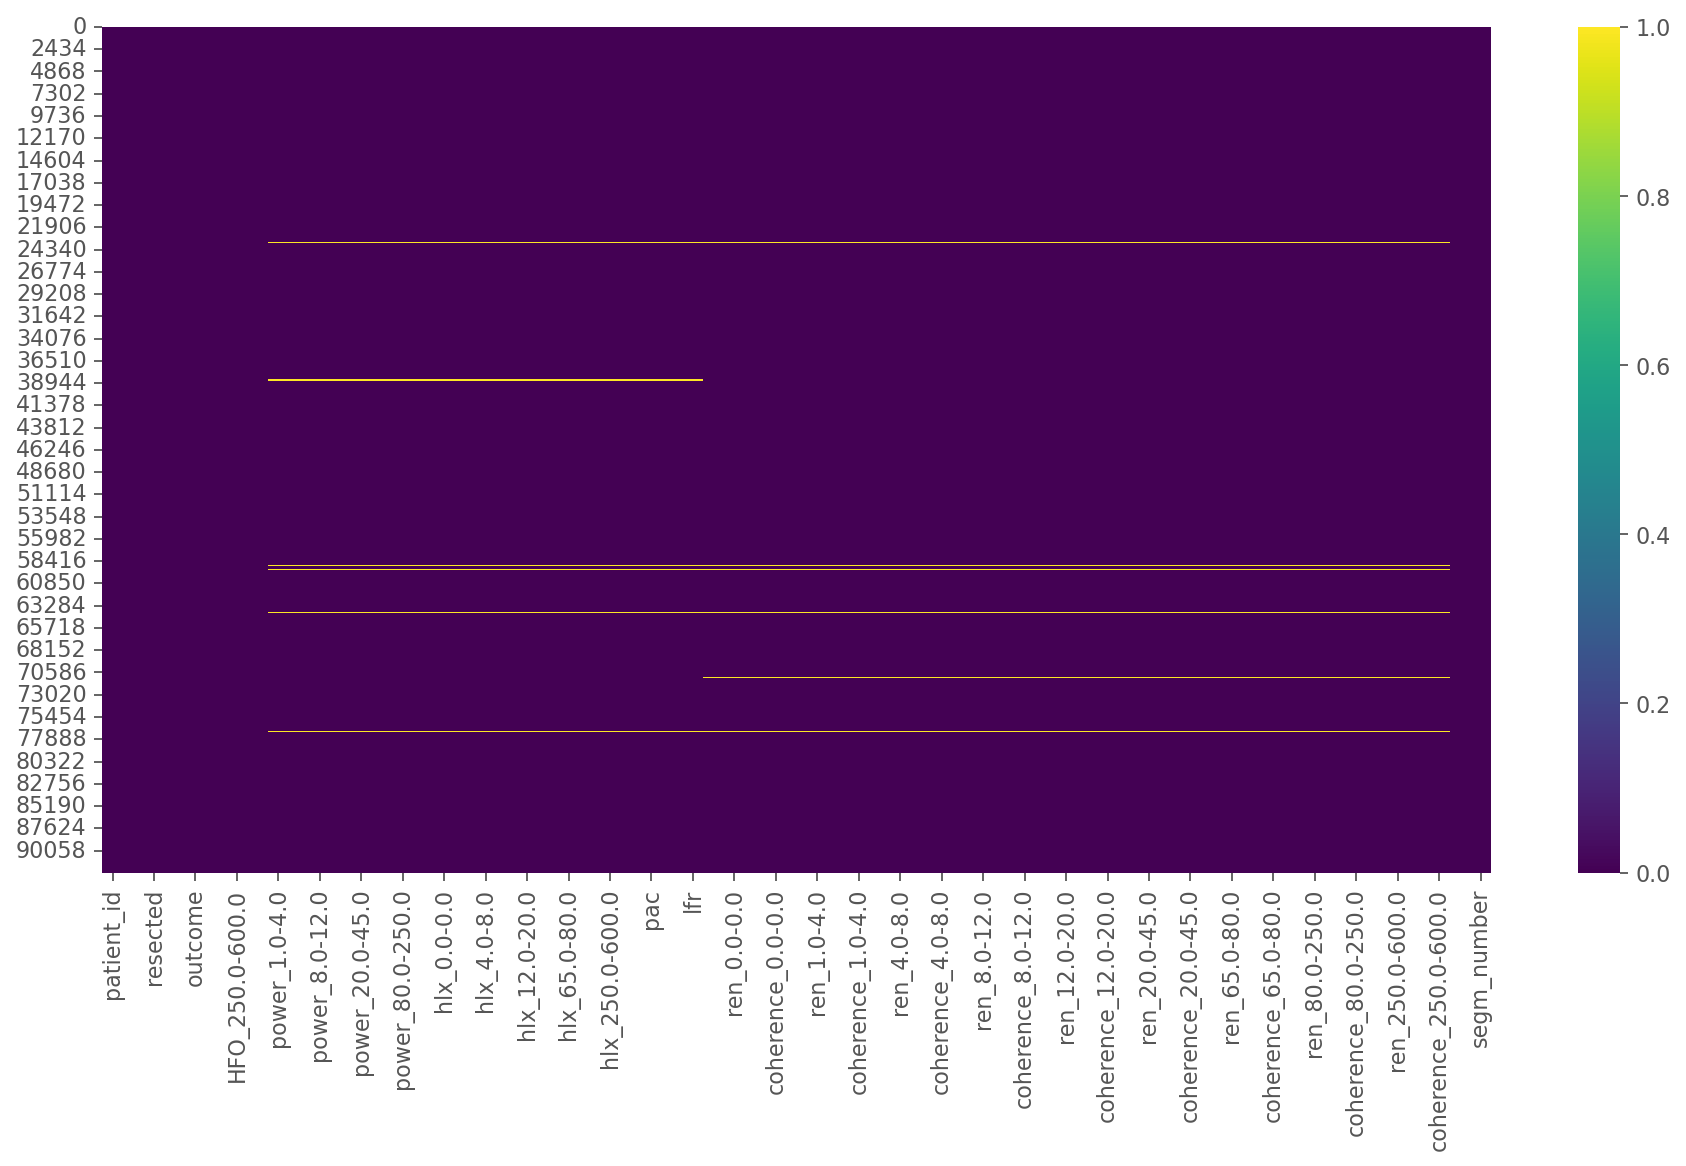

In [5]:
# Show null in columns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['figure.dpi'] = 160
sns.heatmap(df.isnull(), cmap = 'viridis', cbar = True);

#pd.options.display.min_rows = 15
#df.isnull().sum()

In [6]:
# Drop "nan" channels across all segments

df_nans = df[df.isnull().any(axis=1)]
for pts in df_nans.patient_id.unique():
    for chns in list(df_nans.loc[df_nans.patient_id == pts,'channel_name'].unique()):
        df = df.drop(df[(df.patient_id == pts) & (df.channel_name == chns)].index)

In [7]:
# Dataframe shape & number of null values 

print(df.shape)
print(df.isna().sum().sum())

(87648, 67)
0


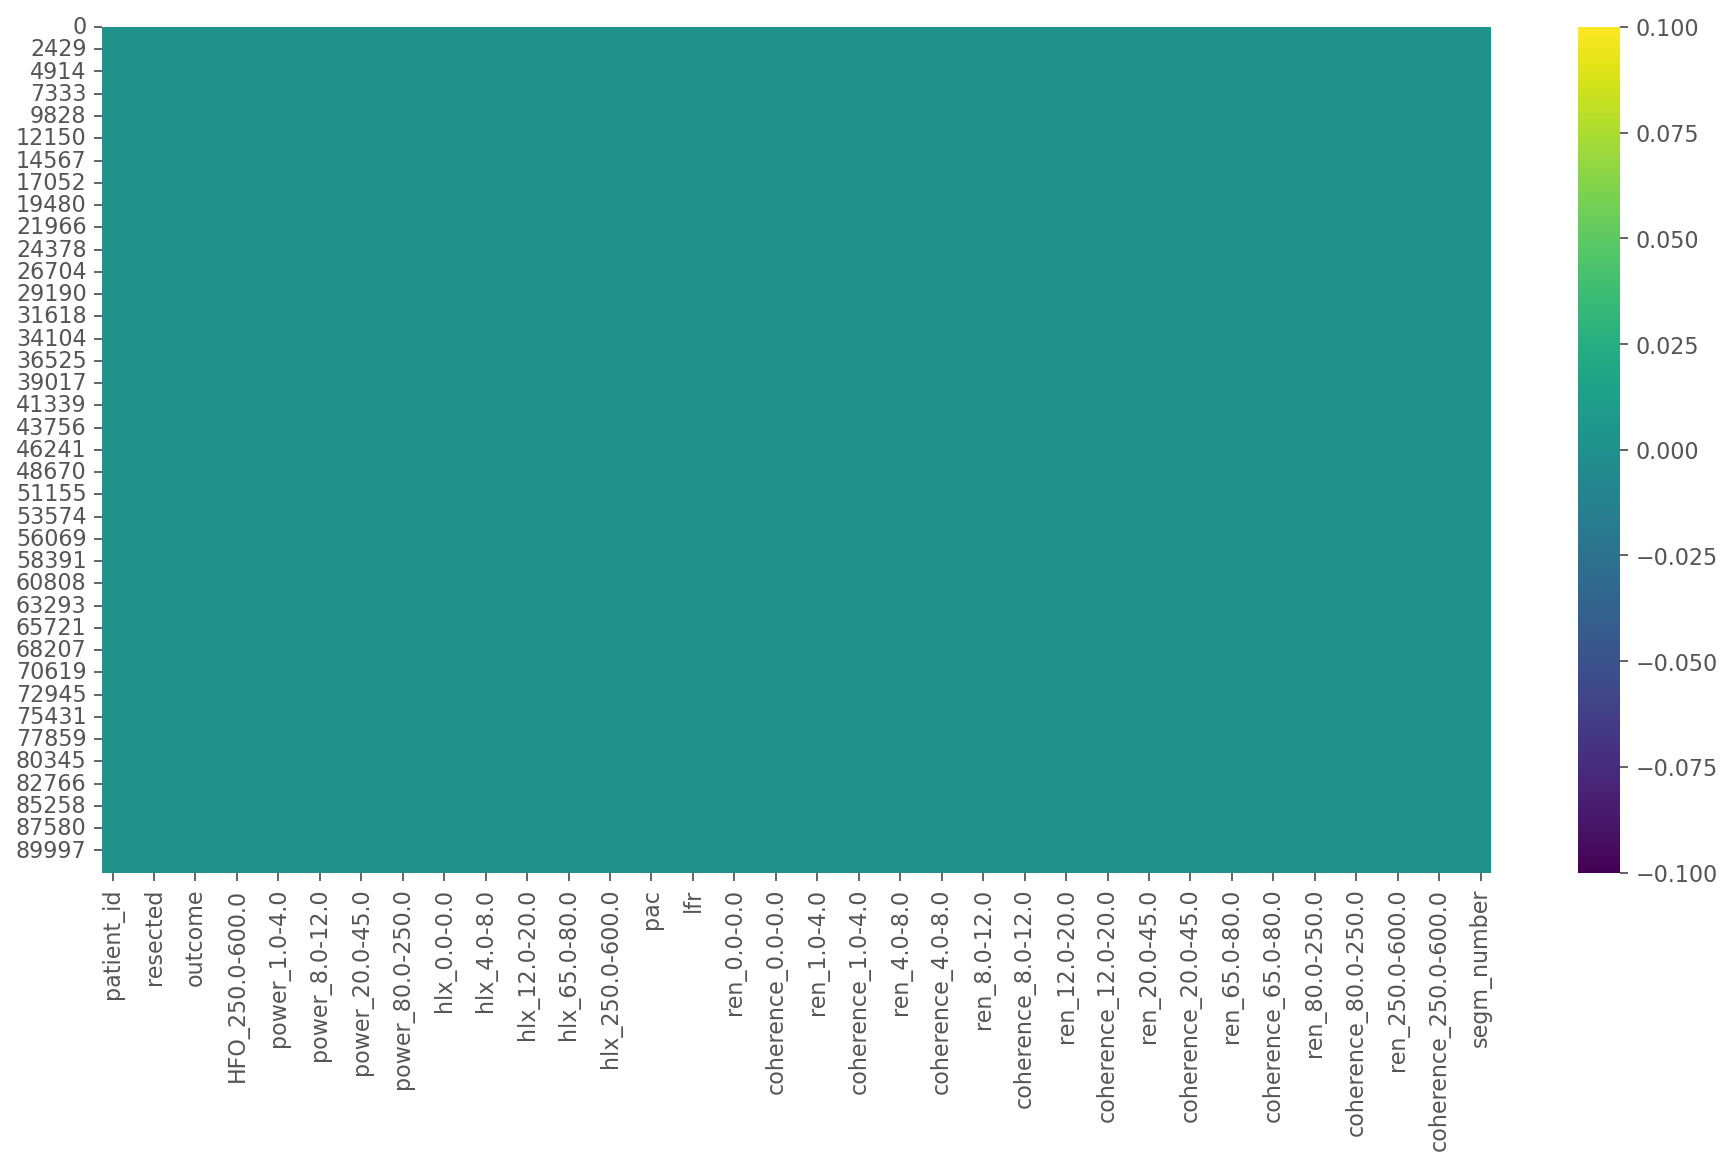

In [8]:
# Show null in columns

sns.heatmap(df.isnull(), cmap = 'viridis', cbar = True);

In [9]:
# Dataframe preparation, target column 

outcome_11 = 11

df = df[df.outcome <= outcome_11]
mask = df.onset_channel == 'NON_SOZ'
df.loc[mask, 'onset_channel'] = 0
mask = df.onset_channel == 'SOZ'
df.loc[mask, 'onset_channel'] = 1
tmp = df['resected'].values * df['onset_channel'].values
df['target'] = tmp.astype(int)
df = df.rename(columns={'spike_rate':'spike_rate_0.0-0.0',
                        'pse':'pse_0.0-0.0',
                        'pac':'pac_0.0-0.0',
                        'fac':'fac_0.0-0.0',
                        'lfr':'lfr_0.0-0.0'})

features = [x for x in df if any(c.isdigit() for c in x)]
features.sort()

In [10]:
# Features list & number of features

print(features)
num_features = len(features)
print(num_features)

['HFO_250.0-600.0', 'HFO_80.0-250.0', 'coherence_0.0-0.0', 'coherence_1.0-4.0', 'coherence_12.0-20.0', 'coherence_20.0-45.0', 'coherence_250.0-600.0', 'coherence_4.0-8.0', 'coherence_65.0-80.0', 'coherence_8.0-12.0', 'coherence_80.0-250.0', 'fac_0.0-0.0', 'hlx_0.0-0.0', 'hlx_1.0-4.0', 'hlx_12.0-20.0', 'hlx_20.0-45.0', 'hlx_250.0-600.0', 'hlx_4.0-8.0', 'hlx_65.0-80.0', 'hlx_8.0-12.0', 'hlx_80.0-250.0', 'lfr_0.0-0.0', 'lin_corr_median_0.0-0.0', 'lin_corr_median_1.0-4.0', 'lin_corr_median_12.0-20.0', 'lin_corr_median_20.0-45.0', 'lin_corr_median_250.0-600.0', 'lin_corr_median_4.0-8.0', 'lin_corr_median_65.0-80.0', 'lin_corr_median_8.0-12.0', 'lin_corr_median_80.0-250.0', 'pac_0.0-0.0', 'phase_sync_0.0-0.0', 'phase_sync_1.0-4.0', 'phase_sync_12.0-20.0', 'phase_sync_20.0-45.0', 'phase_sync_250.0-600.0', 'phase_sync_4.0-8.0', 'phase_sync_65.0-80.0', 'phase_sync_8.0-12.0', 'phase_sync_80.0-250.0', 'power_1.0-4.0', 'power_12.0-20.0', 'power_20.0-45.0', 'power_250.0-600.0', 'power_4.0-8.0', 'po

In [11]:
# Drop no target pts

target = 'target'
for pts in df.patient_id.unique():
    if sum(df.loc[df.patient_id == pts,target]) == 0:
        #print('patient',str(pts),'does not have target - droping this patient')
        df = df[df.patient_id != pts]

In [12]:
# Target values

#target = df.loc[:,"target"]
#print(target)

In [13]:
# Keep only segm_type = 4 

df = df.loc[df['segm_type'] == 4]
print(df.shape)
df.head()

(1959, 68)


,patient_id,channel_name,resected,onset_channel,outcome,HFO_80.0-250.0,HFO_250.0-600.0,spike_rate_0.0-0.0,power_1.0-4.0,power_4.0-8.0,...,ren_80.0-250.0,phase_sync_80.0-250.0,coherence_80.0-250.0,lin_corr_median_250.0-600.0,ren_250.0-600.0,phase_sync_250.0-600.0,coherence_250.0-600.0,segm_type,segm_number,target
34674,583,ra1,0,0,11.0,19,56,50,0.526201,0.474988,...,0.008171,0.962278,0.992315,0.951701,0.015386,0.894617,0.968141,4,0,0
34675,583,ra2,0,0,11.0,35,62,86,0.560877,0.560381,...,0.001929,0.989986,0.998410,0.982513,0.007849,0.952962,0.988048,4,0,0
34676,583,ra3,0,0,11.0,36,66,101,0.558763,0.576171,...,0.002038,0.989737,0.998386,0.982065,0.007308,0.951814,0.987657,4,0,0
34677,583,ra4,0,0,11.0,47,66,102,0.554024,0.565439,...,0.005044,0.975965,0.995656,0.975849,0.009962,0.941062,0.984107,4,0,0
34678,583,ra5,0,0,11.0,32,75,96,0.649021,0.658895,...,0.009224,0.944790,0.987954,0.980963,0.007094,0.949647,0.986945,4,0,0


In [14]:
# Number of unique patients

print(len(df.patient_id.unique()))
patients = df.patient_id.unique()
patients = np.sort(patients)
patients

18


array([  61,   63,   71,   77,   82,   89,   93,  583,  657,  717,  723,
        953,  965, 1002, 1021, 1041, 1043, 1630])

In [15]:
# Target in numbers based on SOZ vs NOZ & resection

df.groupby(['target', 'patient_id'])['target'].count()

target  patient_id
0       61            141
        63            117
        71            164
        77            166
        82             74
        89            162
        93            154
        583            84
        657            42
        717            64
        723            75
        953            81
        965            83
        1002           61
        1021           41
        1041           91
        1043           62
        1630          161
1       61              9
        63              3
        71              5
        77              2
        82             11
        89              8
        93              6
        583             3
        657             3
        717             6
        723            11
        953             7
        965             3
        1002            6
        1021           18
        1041           16
        1043            9
        1630           10
Name: target, dtype: int64

In [16]:
# Scale selected features with standard scaler (z-score)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder        
scaler = StandardScaler()
for pts in df.patient_id.unique(): 
    df.loc[df.patient_id == pts,features] = scaler.fit_transform(df.loc[df.patient_id == pts,features])

In [17]:
# Dataframe info

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 34674 to 40452
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_id                   1959 non-null   int64  
 1   channel_name                 1959 non-null   object 
 2   resected                     1959 non-null   int64  
 3   onset_channel                1959 non-null   object 
 4   outcome                      1959 non-null   float64
 5   HFO_80.0-250.0               1959 non-null   float64
 6   HFO_250.0-600.0              1959 non-null   float64
 7   spike_rate_0.0-0.0           1959 non-null   float64
 8   power_1.0-4.0                1959 non-null   float64
 9   power_4.0-8.0                1959 non-null   float64
 10  power_8.0-12.0               1959 non-null   float64
 11  power_12.0-20.0              1959 non-null   float64
 12  power_20.0-45.0              1959 non-null   float64
 13  power_65.0-80

## LazyClassifier
> --- demonstration

In [18]:
# Create a list of the columns you want to keep
columns_to_keep = ['patient_id'] + [col for col in df.columns[5:65]] + ['target']

# Use the list of columns to keep to create a new DataFrame with only those columns
lazy_df = df[columns_to_keep]

In [19]:
# View lazy_df

lazy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 34674 to 40452
Data columns (total 62 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_id                   1959 non-null   int64  
 1   HFO_80.0-250.0               1959 non-null   float64
 2   HFO_250.0-600.0              1959 non-null   float64
 3   spike_rate_0.0-0.0           1959 non-null   float64
 4   power_1.0-4.0                1959 non-null   float64
 5   power_4.0-8.0                1959 non-null   float64
 6   power_8.0-12.0               1959 non-null   float64
 7   power_12.0-20.0              1959 non-null   float64
 8   power_20.0-45.0              1959 non-null   float64
 9   power_65.0-80.0              1959 non-null   float64
 10  power_80.0-250.0             1959 non-null   float64
 11  power_250.0-600.0            1959 non-null   float64
 12  hlx_0.0-0.0                  1959 non-null   float64
 13  hlx_1.0-4.0  

In [20]:
# Run LazyClassifier

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score

# define the group column
group = 'patient_id'

# split the data into X and y
X = lazy_df.drop(columns=target)
y = lazy_df[target]

# define the base classifier
base_clf = RandomForestClassifier(random_state=0, verbose=2)

logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(X, y, groups=df[group]):
    X_train, X_test = X.iloc[train_index].drop(columns=[group]), X.iloc[test_index].drop(columns=[group])
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    selected_patient_id = df.iloc[test_index][group].unique()
    print("Selected patient ID: ", selected_patient_id)
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models,predictions =clf.fit(X_train, X_test, y_train, y_test)
    print(models)

Selected patient ID:  [61]


100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.75               0.71     0.71      0.81   
GaussianNB                         0.81               0.69     0.69      0.85   
BernoulliNB                        0.65               0.66     0.66      0.74   
Perceptron                         0.91               0.59     0.59      0.91   
PassiveAggressiveClassifier        0.81               0.59     0.59      0.85   
BaggingClassifier                  0.95               0.56     0.56      0.93   
LGBMClassifier                     0.95               0.56     0.56      0.93   
SGDClassifier                      0.92               0.54     0.54      0.91   
ExtraTreeClassifier                0.90               0.53     0.53      0.90   
ExtraTreesClassifier               0.94               0.50     0.50      0.91   
RandomForestClassifier      

100%|███████████████████████████████████████████| 29/29 [00:04<00:00,  7.20it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
GaussianNB                         0.82               0.74     0.74      0.88   
NearestCentroid                    0.76               0.71     0.71      0.84   
BernoulliNB                        0.70               0.68     0.68      0.80   
PassiveAggressiveClassifier        0.94               0.65     0.65      0.95   
LinearSVC                          0.97               0.50     0.50      0.96   
XGBClassifier                      0.97               0.50     0.50      0.96   
SVC                                0.97               0.50     0.50      0.96   
RidgeClassifierCV                  0.97               0.50     0.50      0.96   
RidgeClassifier                    0.97               0.50     0.50      0.96   
RandomForestClassifier             0.97               0.50     0.50      0.96   
QuadraticDiscriminantAnalysi

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.51it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
GaussianNB                         0.79               0.80     0.80      0.86   
LogisticRegression                 0.95               0.68     0.68      0.96   
ExtraTreeClassifier                0.91               0.66     0.66      0.93   
PassiveAggressiveClassifier        0.89               0.65     0.65      0.92   
DecisionTreeClassifier             0.94               0.58     0.58      0.95   
NearestCentroid                    0.75               0.58     0.58      0.83   
LinearDiscriminantAnalysis         0.92               0.57     0.57      0.93   
LGBMClassifier                     0.97               0.50     0.50      0.96   
DummyClassifier                    0.97               0.50     0.50      0.96   
ExtraTreesClassifier               0.97               0.50     0.50      0.96   
RandomForestClassifier      

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.62it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.99               0.99     0.99      0.99   
GaussianNB                         0.79               0.89     0.89      0.87   
NearestCentroid                    0.71               0.85     0.85      0.82   
BernoulliNB                        0.64               0.82     0.82      0.77   
XGBClassifier                      0.99               0.75     0.75      0.99   
LGBMClassifier                     0.98               0.74     0.74      0.98   
BaggingClassifier                  0.98               0.74     0.74      0.98   
DummyClassifier                    0.99               0.50     0.50      0.98   
KNeighborsClassifier               0.99               0.50     0.50      0.98   
SVC                                0.99               0.50     0.50      0.98   
QuadraticDiscriminantAnalysi

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.37it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.64               0.60     0.60      0.69   
ExtraTreeClassifier                0.86               0.57     0.57      0.84   
AdaBoostClassifier                 0.88               0.55     0.55      0.84   
DecisionTreeClassifier             0.78               0.52     0.52      0.78   
NearestCentroid                    0.69               0.51     0.51      0.73   
BaggingClassifier                  0.87               0.50     0.50      0.81   
XGBClassifier                      0.87               0.50     0.50      0.81   
SVC                                0.87               0.50     0.50      0.81   
RidgeClassifierCV                  0.87               0.50     0.50      0.81   
RidgeClassifier                    0.87               0.50     0.50      0.81   
RandomForestClassifier      

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.28it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.72               0.68     0.68      0.80   
BernoulliNB                        0.55               0.65     0.65      0.67   
GaussianNB                         0.75               0.57     0.57      0.82   
LinearDiscriminantAnalysis         0.93               0.55     0.55      0.92   
SGDClassifier                      0.88               0.52     0.52      0.90   
AdaBoostClassifier                 0.95               0.50     0.50      0.93   
XGBClassifier                      0.95               0.50     0.50      0.93   
SVC                                0.95               0.50     0.50      0.93   
RidgeClassifierCV                  0.95               0.50     0.50      0.93   
RandomForestClassifier             0.95               0.50     0.50      0.93   
QuadraticDiscriminantAnalysi

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.59it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SGDClassifier                      0.97               0.75     0.75      0.97   
GaussianNB                         0.79               0.73     0.73      0.85   
NearestCentroid                    0.72               0.69     0.69      0.81   
BernoulliNB                        0.67               0.67     0.67      0.77   
RidgeClassifierCV                  0.97               0.67     0.67      0.97   
RidgeClassifier                    0.97               0.67     0.67      0.97   
LogisticRegression                 0.97               0.67     0.67      0.97   
LinearDiscriminantAnalysis         0.97               0.66     0.66      0.96   
DecisionTreeClassifier             0.91               0.63     0.63      0.92   
AdaBoostClassifier                 0.97               0.58     0.58      0.96   
Perceptron                  

100%|███████████████████████████████████████████| 29/29 [00:04<00:00,  7.25it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
Perceptron                         0.99               0.99     0.99      0.99   
LinearDiscriminantAnalysis         0.97               0.98     0.98      0.97   
GaussianNB                         0.89               0.94     0.94      0.92   
DecisionTreeClassifier             0.85               0.92     0.92      0.90   
NearestCentroid                    0.84               0.92     0.92      0.89   
LinearSVC                          0.97               0.82     0.82      0.97   
BaggingClassifier                  0.94               0.81     0.81      0.95   
XGBClassifier                      0.94               0.81     0.81      0.95   
ExtraTreeClassifier                0.90               0.79     0.79      0.92   
BernoulliNB                        0.74               0.70     0.70      0.82   
LogisticRegression          

100%|███████████████████████████████████████████| 29/29 [00:04<00:00,  6.83it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.78               0.88     0.88      0.83   
ExtraTreeClassifier                0.91               0.80     0.80      0.92   
DecisionTreeClassifier             0.82               0.75     0.75      0.86   
KNeighborsClassifier               0.96               0.67     0.67      0.94   
Perceptron                         0.91               0.64     0.64      0.91   
XGBClassifier                      0.89               0.63     0.63      0.90   
RandomForestClassifier             0.87               0.62     0.62      0.88   
LinearDiscriminantAnalysis         0.84               0.61     0.61      0.87   
BaggingClassifier                  0.84               0.61     0.61      0.87   
LGBMClassifier                     0.84               0.61     0.61      0.87   
GaussianNB                  

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.33it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LinearDiscriminantAnalysis         0.97               0.83     0.83      0.97   
Perceptron                         0.96               0.75     0.75      0.95   
AdaBoostClassifier                 0.94               0.67     0.67      0.93   
LogisticRegression                 0.94               0.67     0.67      0.93   
PassiveAggressiveClassifier        0.86               0.62     0.62      0.87   
KNeighborsClassifier               0.93               0.58     0.58      0.90   
RidgeClassifierCV                  0.93               0.58     0.58      0.90   
RidgeClassifier                    0.93               0.58     0.58      0.90   
QuadraticDiscriminantAnalysis      0.93               0.58     0.58      0.90   
LinearSVC                          0.93               0.58     0.58      0.90   
GaussianNB                  

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.35it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
Perceptron                         0.95               0.97     0.97      0.96   
GaussianNB                         0.92               0.88     0.88      0.92   
DecisionTreeClassifier             0.94               0.85     0.85      0.94   
LinearDiscriminantAnalysis         0.95               0.82     0.82      0.95   
NearestCentroid                    0.83               0.78     0.78      0.85   
BernoulliNB                        0.81               0.78     0.78      0.84   
PassiveAggressiveClassifier        0.94               0.77     0.77      0.93   
LinearSVC                          0.93               0.73     0.73      0.92   
XGBClassifier                      0.93               0.73     0.73      0.92   
KNeighborsClassifier               0.92               0.72     0.72      0.91   
AdaBoostClassifier          

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.50it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.78               0.88     0.88      0.83   
BernoulliNB                        0.75               0.86     0.86      0.81   
LogisticRegression                 0.97               0.79     0.79      0.96   
AdaBoostClassifier                 0.95               0.78     0.78      0.95   
LinearDiscriminantAnalysis         0.95               0.78     0.78      0.95   
ExtraTreeClassifier                0.90               0.75     0.75      0.91   
GaussianNB                         0.86               0.73     0.73      0.88   
RidgeClassifierCV                  0.95               0.71     0.71      0.95   
LinearSVC                          0.95               0.71     0.71      0.95   
PassiveAggressiveClassifier        0.94               0.71     0.71      0.94   
DecisionTreeClassifier      

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.44it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LinearDiscriminantAnalysis         0.92               0.80     0.80      0.94   
LogisticRegression                 0.90               0.79     0.79      0.92   
GaussianNB                         0.86               0.77     0.77      0.90   
Perceptron                         0.83               0.75     0.75      0.88   
NearestCentroid                    0.81               0.74     0.74      0.87   
BernoulliNB                        0.76               0.71     0.71      0.83   
AdaBoostClassifier                 0.94               0.65     0.65      0.95   
SGDClassifier                      0.93               0.64     0.64      0.94   
XGBClassifier                      0.92               0.64     0.64      0.93   
LinearSVC                          0.92               0.64     0.64      0.93   
PassiveAggressiveClassifier 

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.41it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
Perceptron                         0.93               0.81     0.81      0.93   
LinearDiscriminantAnalysis         0.93               0.73     0.73      0.92   
XGBClassifier                      0.93               0.73     0.73      0.92   
DecisionTreeClassifier             0.90               0.72     0.72      0.90   
SGDClassifier                      0.87               0.70     0.70      0.88   
GaussianNB                         0.87               0.70     0.70      0.88   
LogisticRegression                 0.94               0.67     0.67      0.93   
NearestCentroid                    0.79               0.66     0.66      0.83   
LGBMClassifier                     0.93               0.66     0.66      0.91   
BernoulliNB                        0.78               0.65     0.65      0.82   
RidgeClassifierCV           

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.29it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.83               0.77     0.77      0.82   
SGDClassifier                      0.83               0.72     0.72      0.81   
GaussianNB                         0.81               0.71     0.71      0.79   
LinearDiscriminantAnalysis         0.81               0.71     0.71      0.79   
AdaBoostClassifier                 0.78               0.65     0.65      0.74   
BernoulliNB                        0.68               0.64     0.64      0.68   
DecisionTreeClassifier             0.75               0.61     0.61      0.70   
XGBClassifier                      0.76               0.61     0.61      0.70   
LGBMClassifier                     0.76               0.61     0.61      0.70   
ExtraTreeClassifier                0.75               0.60     0.60      0.69   
LinearSVC                   

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.39it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
Perceptron                         0.81               0.58     0.58      0.80   
ExtraTreesClassifier               0.85               0.53     0.53      0.80   
KNeighborsClassifier               0.85               0.53     0.53      0.80   
DecisionTreeClassifier             0.80               0.52     0.52      0.78   
LabelPropagation                   0.82               0.51     0.51      0.78   
LabelSpreading                     0.82               0.51     0.51      0.78   
RandomForestClassifier             0.81               0.50     0.50      0.78   
ExtraTreeClassifier                0.81               0.50     0.50      0.78   
SVC                                0.85               0.50     0.50      0.78   
CalibratedClassifierCV             0.85               0.50     0.50      0.78   
DummyClassifier             

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.57it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LabelPropagation                   0.85               0.53     0.53      0.82   
LabelSpreading                     0.85               0.53     0.53      0.82   
BernoulliNB                        0.63               0.51     0.51      0.69   
QuadraticDiscriminantAnalysis      0.87               0.50     0.50      0.81   
DummyClassifier                    0.87               0.50     0.50      0.81   
ExtraTreesClassifier               0.87               0.50     0.50      0.81   
KNeighborsClassifier               0.87               0.50     0.50      0.81   
RandomForestClassifier             0.87               0.50     0.50      0.81   
LinearSVC                          0.86               0.49     0.49      0.81   
CalibratedClassifierCV             0.86               0.49     0.49      0.81   
SVC                         

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  7.69it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
Perceptron                         0.95               0.83     0.83      0.96   
LinearDiscriminantAnalysis         0.96               0.79     0.79      0.96   
LinearSVC                          0.96               0.75     0.75      0.96   
PassiveAggressiveClassifier        0.96               0.75     0.75      0.96   
LogisticRegression                 0.96               0.74     0.74      0.96   
AdaBoostClassifier                 0.96               0.74     0.74      0.96   
XGBClassifier                      0.96               0.70     0.70      0.96   
LGBMClassifier                     0.96               0.70     0.70      0.95   
GaussianNB                         0.80               0.66     0.66      0.84   
ExtraTreeClassifier                0.88               0.65     0.65      0.89   
RandomForestClassifier      

## H2o AutoML
> --- demonstration

In [21]:
import h2o
from h2o.automl import H2OAutoML

# Initialize h2o
h2o.init()

# Convert pandas dataframe to H2OFrame
hf = h2o.H2OFrame(df)

# Convert patient_id & target variable to categorical
hf['target'] = hf['target'].asfactor()
hf['patient_id'] = hf['patient_id'].asfactor()

# Split data into training and testing sets
train_df, test_df = hf.split_frame(ratios=[.8])

# Define target and feature variables
target = "target"
features = list(features)

# Convert numpy ndarray to list of strings
patients = patients.tolist()
patients = list(map(str, patients))


for patient in patients:
    
    # Create a patient mask
    patient_mask = train_df['patient_id'] != patient
    
    # Create a new train and test dataframe with the patient left out
    train_df_leave_patient_out = train_df[patient_mask]
    test_df_leave_patient_out = test_df[test_df['patient_id'] == patient]
    
    # Define target and feature variables
    y = target
    X = features
    
    # Run AutoML
    aml = H2OAutoML(max_models=10, seed=1)
    aml.train(x=X, y=y, training_frame=train_df_leave_patient_out)
    
    # Get the best model
    best_model = aml.leader
    
    # Make predictions on the test set
    predictions = best_model.predict(test_df_leave_patient_out)
    
    # Evaluate the model performance
    try:
        performance = best_model.model_performance(test_df_leave_patient_out)
        print("Patient ID: ", patient)
        print("Model Leader: ", best_model.model_id)
        print("Predictions: ", predictions)
        print("Performance: ", performance)
        print("-----------------------------")
    except Exception as e:
        print("Error for patient id: ", patient)
        print(str(e))
        print("-----------------------------")

        # Shut down h2o
h2o.cluster().shutdown()


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu222.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu222.04, mixed mode, sharing)
  Starting server from /home/marek/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpd_jyi8cj
  JVM stdout: /tmp/tmpd_jyi8cj/h2o_marek_started_from_python.out
  JVM stderr: /tmp/tmpd_jyi8cj/h2o_marek_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,3 months and 27 days !!!
H2O_cluster_name:,H2O_from_python_marek_vkeaz7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.744 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Patient ID:  61
Model Leader:  StackedEnsemble_AllModels_1_AutoML_1_20230115_141208
Predictions:    predict        p0          p1
        0  0.954612  0.0453876
        0  0.97446   0.0255399
        0  0.986478  0.0135219
        0  0.970534  0.0294657
        0  0.973465  0.0265347
        0  0.972906  0.0270942
        0  0.996323  0.00367673
        0  0.91616   0.0838397
        0  0.996512  0.00348795
        0  0.964335  0.035665
[34 rows x 3 columns]

Performance:  ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.05389346188737862
RMSE: 0.23214965407550928
LogLoss: 0.19763288926984793
AUC: 0.84375
AUCPR: 0.15881940844696762
Gini: 0.6875
Null degrees of freedom: 33
Resid

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Patient ID:  77
Model Leader:  StackedEnsemble_BestOfFamily_1_AutoML_4_20230115_141305
Predictions:    predict        p0           p1
        0  0.997633  0.00236718
        0  0.988638  0.0113623
        0  0.986529  0.0134706
        0  0.997347  0.00265265
        0  0.998604  0.00139645
        0  0.971772  0.0282278
        0  0.953796  0.0462037
        0  0.98154   0.0184598
        0  0.999146  0.000854312
        0  0.993893  0.00610711
[31 rows x 3 columns]

Performance:  ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.023257883077175932
RMSE: 0.15250535425740283
LogLoss: 0.07796989116590063
AUC: 0.9666666666666667
AUCPR: 0.3068528194400547
Gini: 0.9333333333333333
Null degrees of freedom: 30
Residual degrees of freedom: 25
Null deviance: 9.800586141519522
Res

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Patient ID:  89
Model Leader:  GBM_2_AutoML_6_20230115_141344
Predictions:    predict        p0          p1
        0  0.972063  0.0279374
        0  0.953826  0.0461743
        0  0.962703  0.0372969
        0  0.991799  0.00820072
        0  0.991504  0.00849552
        0  0.973375  0.0266251
        0  0.877756  0.122244
        0  0.971287  0.0287127
        0  0.940291  0.0597091
        0  0.959888  0.0401116
[36 rows x 3 columns]

Performance:  ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.047289633132713414
RMSE: 0.2174617969499779
LogLoss: 0.18079522136533635
Mean Per-Class Error: 0.25
AUC: 0.7941176470588235
AUCPR: 0.5482303520370024
Gini: 0.588235294117647

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16847973499767896
       0    1    Error    Rate
-----  ---  

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Patient ID:  583
Model Leader:  GBM_4_AutoML_8_20230115_141420
Predictions:    predict        p0          p1
        0  0.928894  0.0711064
        0  0.956382  0.0436178
        0  0.993574  0.00642604
        0  0.993976  0.00602415
        0  0.988281  0.0117186
        0  0.992863  0.00713743
        0  0.981753  0.0182468
        0  0.992782  0.00721772
        0  0.993331  0.00666906
        0  0.99451   0.00549049
[20 rows x 3 columns]

Performance:  ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08943142113900236
RMSE: 0.29905086714303697
LogLoss: 0.25062322285920574
Mean Per-Class Error: 0.027777777777777776
AUC: 0.9444444444444444
AUCPR: 0.45069385566594516
Gini: 0.8888888888888888

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10215003078629574
       0    1    Er

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Patient ID:  723
Model Leader:  GBM_4_AutoML_11_20230115_141511
Predictions:    predict        p0          p1
        0  0.992706  0.00729398
        0  0.992848  0.00715244
        0  0.995144  0.00485634
        0  0.994199  0.00580112
        0  0.987105  0.0128945
        0  0.994529  0.00547098
        0  0.99521   0.0047904
        0  0.995148  0.00485166
        0  0.989963  0.0100372
        1  0.339851  0.660149
[17 rows x 3 columns]

Performance:  ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08254881739901145
RMSE: 0.28731309994327
LogLoss: 0.22095154196098846
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18050274085666188
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      14   0    

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Patient ID:  965
Model Leader:  StackedEnsemble_AllModels_1_AutoML_13_20230115_141545
Predictions:    predict        p0          p1
        1  0.470054  0.529946
        1  0.660339  0.339661
        0  0.942182  0.0578178
        1  0.47065   0.52935
        0  0.844647  0.155353
        0  0.91826   0.0817405
        0  0.970151  0.029849
        1  0.225082  0.774918
        1  0.3014    0.6986
        0  0.993869  0.00613057
[19 rows x 3 columns]

Performance:  ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.14157187281678651
RMSE: 0.3762603790153655
LogLoss: 0.41310680138110806
AUC: 0.5555555555555556
AUCPR: 0.05773571474892947
Gini: 0.11111111111111116
Null degrees of freedom: 18
Residual degrees of freedom: 11
Null deviance: 7.924862136419194
Residual deviance: 1

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Patient ID:  1041
Model Leader:  StackedEnsemble_BestOfFamily_1_AutoML_16_20230115_141646
Predictions:    predict        p0           p1
        0  0.998591  0.0014093
        0  0.99909   0.000909695
        0  0.877227  0.122773
        1  0.699836  0.300164
        0  0.987021  0.012979
        0  0.95275   0.0472498
        0  0.964057  0.0359431
        0  0.998855  0.00114516
        0  0.999035  0.00096511
        0  0.99892   0.00107972
[16 rows x 3 columns]

Performance:  ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.12672065436040789
RMSE: 0.3559784464829407
LogLoss: 0.5141815734350257
AUC: 0.6428571428571429
AUCPR: 0.1531187194980128
Gini: 0.2857142857142858
Null degrees of freedom: 15
Residual degrees of freedom: 11
Null deviance: 12.901781005956057
Residu

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Patient ID:  1630
Model Leader:  GBM_1_AutoML_18_20230115_141725
Predictions:    predict        p0          p1
        0  0.989699  0.0103013
        0  0.986684  0.0133165
        0  0.993704  0.00629567
        0  0.982671  0.0173287
        0  0.994223  0.00577725
        0  0.992641  0.00735936
        0  0.950338  0.049662
        0  0.989122  0.0108777
        0  0.993275  0.00672461
        0  0.992561  0.00743942
[30 rows x 3 columns]

Performance:  ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.013360769377812208
RMSE: 0.11558879434362229
LogLoss: 0.063772056120539
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46625582183076375
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      29   0  